# Notebook - Análise da evasão

Dados do Instituto de Ciências Exatas (IE).

### Importando bibliotecas:

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool

import utils
import pre_process

%matplotlib inline

In [79]:
import importlib
importlib.reload(utils)

<module 'utils' from '/home/tiago/git/trj-academica/pipeline/utils.py'>

 ### Leitura dos dados

In [2]:
DATA_FILE = '../data/ie_data.csv'
data_pre = pd.read_csv(DATA_FILE, sep=';', low_memory=False)

## Pré-Processamento

In [3]:
attrs = []
data_pre = pre_process.format_data(data_pre)
data_pre = pre_process.erase_attr(data_pre)
data_pre = data_pre.dropna()

data_pre = pre_process.public_school(data_pre, attrs)
data_pre = pre_process.dropout(data_pre, attrs)
data_pre = pre_process.course(data_pre, attrs)
data_pre = pre_process.gender(data_pre, attrs)
data_pre = pre_process.quota(data_pre, attrs)
data_pre = pre_process.entry(data_pre, attrs)

data_pre = pre_process.cic_courses(data_pre)
data_pre = pre_process.erase_interal_transfer_students(data_pre)

Divide dataframe by course:

In [80]:
data_course = pre_process.divide_course(data_pre)
data_course['all'] = data_pre

### Frequência das disciplinas

In [ ]:
# for course, data in data_course.items():
#     print('\n')
#     print(course)
#     print(data['nome_disciplina'].value_counts()[:20])

### Process Subjects and CEP

The Subjects are processed for each course individually, and Cep needs to be processed before all other attributes and drop_duplicates, otherwise it takes too long to process.

In [81]:
keys = data_course.keys()
data_analysis = {}
for course in keys:
    print(course)
    data = data_course[course].copy()
    attrs_copy = attrs.copy()

    # Process subjects for each 
    data = pre_process.subjects(data, attrs_copy)

    # Cep needs to be processed before drop_duplicates,
    # otherwise it takes too long to process.
    data = data[attrs_copy+['cep', 'aluno']].drop_duplicates()
    data = pre_process.cep(data, attrs_copy)
    data_analysis[course] = data.copy()  # make a copy for data analysis
    data = data[attrs_copy].drop_duplicates()
    data_course[course] = data.copy()

ciência da computação
1_calculo 1                               1564
1_computacao basica                       1553
1_fisica 1                                1472
1_fisica 1 experimental                   1453
1_leitura e producao de textos            1346
1_ingles instrumental 1                   1293
2_estruturas de dados                     1036
2_calculo 2                                883
2_probabilidade e estatistica              838
2_fisica 2 experimental                    676
2_fisica 2                                 674
2_fisica 1                                 435
1_pratica desportiva 1                     426
2_calculo 1                                359
2_computacao basica                        355
2_fisica 1 experimental                    346
1_estudo de problemas brasileiros 1        240
2_introducao a filosofia                   167
1_ingles: expressao escrita 1              166
1_introducao a morfossintaxe do ingles     163
Name: nome_disciplina, dtype: int64
co

Remove course attribute from individual dataframes:

(Preciso remodelar o pipeline antes de retirar esse atributo)

In [6]:
# for course in keys:
#     if course != 'all':
#         data_course[course].drop('course', axis=1, inplace=True)

In [82]:
data_process = data_course.copy()

Tamanho da base:

In [ ]:
# for course in data_course.keys():
#     print(f'{course} = {data_course[course].shape}')

Desbalanceamento da base:

In [ ]:
# for course in data_course.keys():
#     print(f'{course}:')
#     freq = data_course[course]['dropout'].value_counts()
#     print(freq)
#     print('\n')

## Testes

In [84]:
date = 20002
utils.date_to_real(date)

2000.5

## Processamento

In [85]:
def process(data):
    output_attr = 'dropout'
    cat_attr = ['course', 'entry']

    X = data.drop(columns=[output_attr])
    y = data[output_attr]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    # dropout imbalance
    output_freq = data[output_attr].value_counts()
    scale = output_freq[0] / output_freq[1]  # negative / positive

    model = CatBoostClassifier(scale_pos_weight=scale)
    model.fit(X_train, y_train, cat_features=cat_attr, plot=False, silent=True)

    predicts = model.predict(X_test)
    predicts = [x == 'True' for x in predicts]
    print('Accuracy score:', accuracy_score(y_test, predicts))
    print('Recall score:', recall_score(y_test, predicts))
    print('Precision score:', precision_score(y_test, predicts))

    # shap importance
    shap_values = model.get_feature_importance(
        Pool(X_test, label=y_test, cat_features=cat_attr), 
        type="ShapValues"
    )
    shap_values = shap_values[:,:-1]
    shap.summary_plot(shap_values, X_test) 

    # fi = model.get_feature_importance(Pool(X_test, label=y_test,cat_features=cat_attr), type='LossFunctionChange')
    # utils.plot_feature_importance(fi, X.columns, 'Catboost')

    return model, X_test

Process all dataframes:


Curso = ciência da computação
Accuracy score: 0.7860262008733624
Recall score: 0.7862903225806451
Precision score: 0.8125


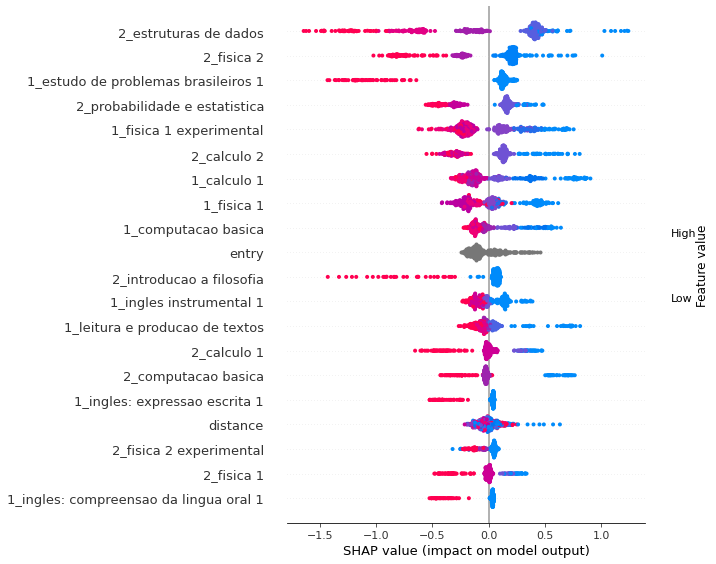


Curso = computação
Accuracy score: 0.7417582417582418
Recall score: 0.7715355805243446
Precision score: 0.8619246861924686


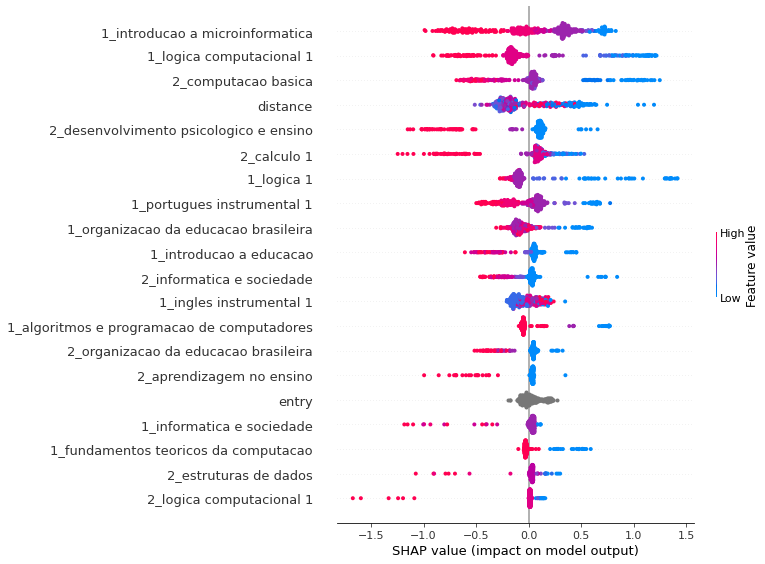


Curso = engenharia de computação
Accuracy score: 0.8300653594771242
Recall score: 0.8229166666666666
Precision score: 0.8977272727272727


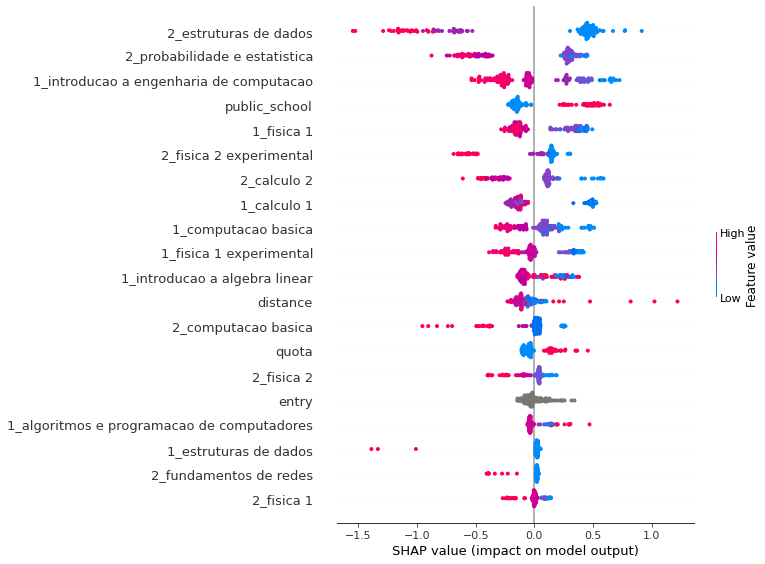


Curso = engenharia mecatrônica
Accuracy score: 0.7810457516339869
Recall score: 0.7101449275362319
Precision score: 0.784


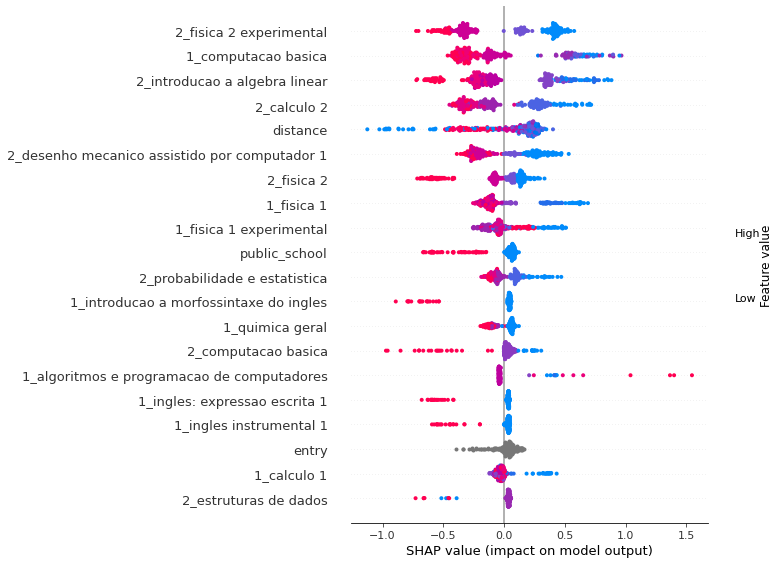


Curso = all
Accuracy score: 0.7915672235481305
Recall score: 0.784741144414169
Precision score: 0.8470588235294118


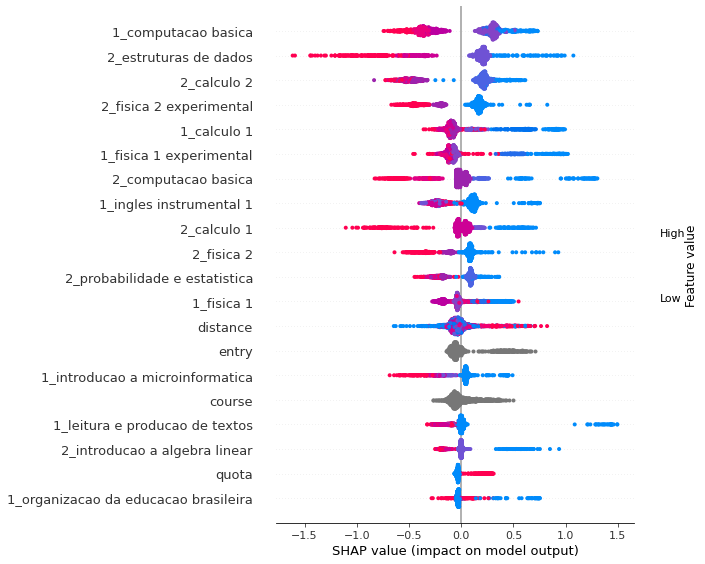

In [86]:
for course, data in data_process.items():
    print(f'\nCurso = {course}')
    model, X_test = process(data)

Process a single dataframe:

Accuracy score: 0.8300653594771242
Recall score: 0.8229166666666666
Precision score: 0.8977272727272727


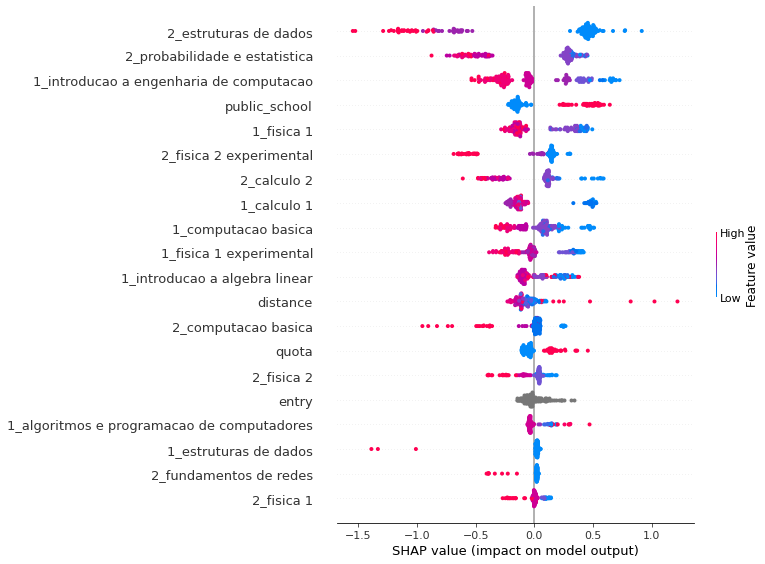

In [88]:
course = 'engenharia de computação'
model, X_test = process(data_process[course])

## Using SHAP

In [90]:
explainer = shap.TreeExplainer(model)
start_index = 0
end_index = len(X_test)
shap_values = explainer.shap_values(X_test[start_index:end_index])

shap.initjs()

In [ ]:
id = 10
shap.force_plot(explainer.expected_value,
                shap_values[id:id+1],
                X_test[id:id+1])

In [ ]:
shap.force_plot(explainer.expected_value,
                shap_values,
                X_test[start_index:end_index])

In [ ]:
shap.summary_plot(shap_values, X_test[start_index:end_index], plot_size=(20,20), max_display=50)

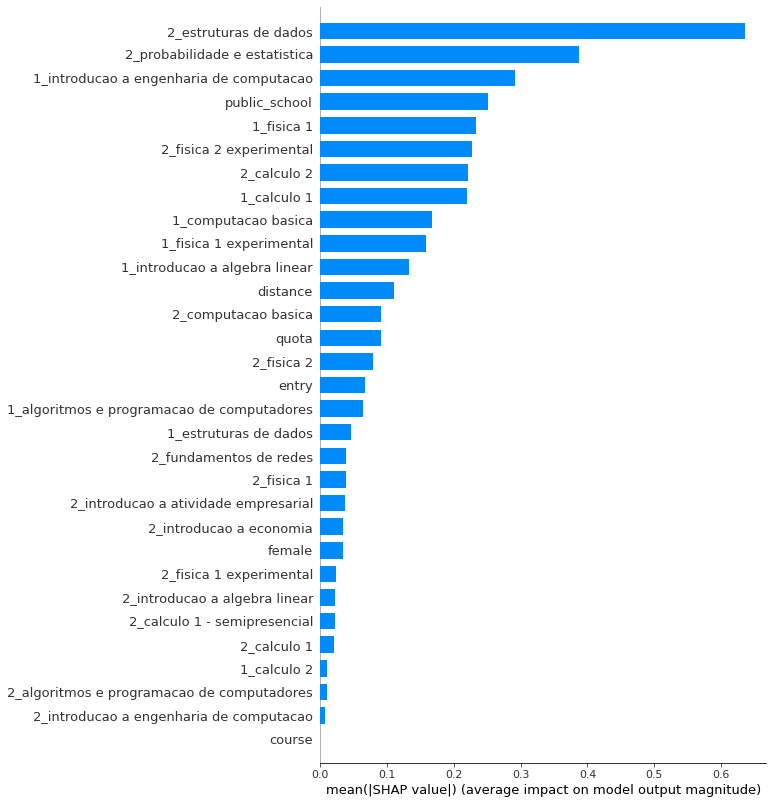

In [91]:
shap.summary_plot(shap_values, X_test, plot_type='bar', max_display=50)

In [ ]:
shap.dependence_plot('1_fisica 1', shap_values, X_test[start_index:end_index], interaction_index='distance')

## Plot Student's House Coordinates

In [ ]:
attr = ['aluno', 'cep', 'dropout', 'course']
# keys = data_analysis.keys()
keys = ['ciência da computação']
for course in keys:
    data = data_analysis[course].copy()[attr].drop_duplicates()
    utils.plot_coordinates(data, course)
    utils.plot_coordinates_density(data, course)